In [ ]:
from ultralytics import YOLO

import matplotlib.pyplot as plt
from PIL import Image
import cv2

import numpy as np
import torch
import json
import easyocr

import time
import os
import gc
import math
import re

from sklearn.cluster import DBSCAN
from collections import defaultdict, Counter

In [2]:
reader = easyocr.Reader(
    lang_list=['en'],
    gpu=False,
    model_storage_directory="model/"
)

Using CPU. Note: This module is much faster with a GPU.


In [3]:
yolo = YOLO("model/yolo-obb.pt")

In [4]:
map_resources = {} 
# path = "/kaggle/input/real-estate"
path = "."
with open(f"{path}/data/mapping.json", "r", encoding="utf-8") as f:
    map_resources["mapping"] = json.load(f)

with open(f"{path}/data/metadata.json", "r", encoding="utf-8") as f:
    map_resources["metadata"] = json.load(f)
    
map_resources["image"] = cv2.cvtColor(cv2.imread(f"{path}/data/map.JPG"), cv2.COLOR_BGR2RGB) 

In [5]:
root_dir = f"{path}/data/design/"
resources = {}

for apartment in os.listdir(root_dir):
    apt_path = os.path.join(root_dir, apartment)
    if not os.path.isdir(apt_path):
        continue

    resources[apartment] = {}
    for floor in os.listdir(apt_path):
        floor_path = os.path.join(apt_path, floor)
        if not os.path.isdir(floor_path):
            continue

        res = {}
        mapping_file = os.path.join(floor_path, "mapping.json")
        if os.path.exists(mapping_file):
            with open(mapping_file, "r", encoding="utf-8") as f:
                res["mapping"] = json.load(f)

        metadata_file = os.path.join(floor_path, "metadata.json")
        if os.path.exists(metadata_file):
            with open(metadata_file, "r", encoding="utf-8") as f:
                res["metadata"] = json.load(f)

        map_file = os.path.join(floor_path, "design.jpg")
        if os.path.exists(map_file):
            res["image"] = cv2.cvtColor(cv2.imread(map_file), cv2.COLOR_BGR2RGB) 

        resources[apartment][floor] = res

In [6]:
def crop_from_original(resources, code):
    tiles_list = resources["mapping"][code]
    offsets = resources["metadata"]
    min_x, min_y = float("inf"), float("inf")
    max_x, max_y = 0, 0

    for tile_name in tiles_list:
        off = offsets[tile_name]
        x, y, w, h = off["x"], off["y"], off["width"], off["height"]

        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x + w)
        max_y = max(max_y, y + h)

    cropped = resources["image"][min_y:max_y, min_x:max_x]
    return cropped

In [7]:
def crop_image_from_info(building_code, floor_number, apartment_number):
    floor_ranges = resources[building_code.replace(".", "")].keys()
    for i, fr in enumerate(floor_ranges):
        try:
            _, start, end = fr.split("_")
            start, end = int(start), int(end)
            if start <= floor_number <= end:
                floor = fr
                break
        except ValueError:
                continue
        
    floor_resources = resources[building_code.replace(".", "")][floor]
    design_cropped = crop_from_original(floor_resources, f'CH{apartment_number:02d}')
    return design_cropped

In [8]:
def bbox_overlap(b1, b2, axis='y', margin=0):
        if axis == 'x':
            return not (b1[1][0]+margin < b2[0][0] or b2[1][0]+margin < b1[0][0])
        else:
            return not (b1[2][1]+margin < b2[0][1] or b2[2][1]+margin < b1[0][1])
            
def crop_building(img, building_code):
    results = reader.readtext(img)
    results_sorted = sorted(results, key=lambda x: x[0][0][0])
    results_sorted = [(bbox, text.replace(",", ".")) for (bbox, text,_) in results_sorted]

    for bbox, text in results_sorted:
        if text == building_code:
            return [text, bbox]

    chosen_results = []
    matched_chars = {}
    code_chars = list(building_code)
    candidate_bboxes = results_sorted.copy()
    
    for last_index, char in enumerate(code_chars):
        next_candidates, tmp = [], []
        for bbox, text in candidate_bboxes:
            if char in text:
                tmp.append((text, bbox))
                next_candidates.append((bbox, text))
                
        if not tmp:
            break
        matched_chars[last_index] = tmp
        candidate_bboxes = next_candidates

    last_matches = matched_chars.get(last_index-1, [])
    chosen_results = None

    for text1, bbox1 in last_matches:
        overlap = next(
            ((other_text, other_bbox) for other_bbox, other_text in results_sorted
             if other_bbox != bbox1 
             and bbox_overlap(bbox1, other_bbox, axis='y') 
             and other_text == building_code[last_index:]),
            None
        )
        if overlap:
            text2, bbox2 = overlap
            merged_text = text1 + text2
            all_x = [pt[0] for pt in bbox1 + bbox2]
            all_y = [pt[1] for pt in bbox1 + bbox2]
            merged_bbox = [
                [min(all_x), min(all_y)],
                [max(all_x), min(all_y)],
                [max(all_x), max(all_y)],
                [min(all_x), max(all_y)]
            ]
            chosen_results = (merged_bbox, merged_text)
    return chosen_results

In [9]:
def crop_building_region(img_resized, chosen_results, building_code,
                         TOP_RATIO=0.25, BOTTOM_RATIO=0.30, SIDE_RATIO=0.25):
    h_img, w_img = img_resized.shape[:2]
    bbox, text = chosen_results
    clean_text = text.upper().replace("O", "0").replace(",", ".").replace(" ", "")
    if clean_text == building_code:
        (x_min, y_min) = bbox[0]
        (x_max, y_max) = bbox[2]

        expand_top = int(TOP_RATIO * h_img)
        expand_bottom = int(BOTTOM_RATIO * h_img)
        expand_side = int(SIDE_RATIO * w_img)

        x_min = max(0, int(x_min - expand_side))
        y_min = max(0, int(y_min - expand_top))
        x_max = min(w_img, int(x_max + expand_side))
        y_max = min(h_img, int(y_max + expand_bottom))

        img_cropped = img_resized[y_min:y_max, x_min:x_max]

        return img_cropped

    print(f"⚠️ Không tìm thấy building_code: {building_code}")
    return None

### Explore design drawings

In [10]:
building_code = "S6.06"
floor_number = 20
apartment_number = 7

design_cropped = crop_image_from_info(
    building_code=building_code,
    floor_number=floor_number,
    apartment_number=apartment_number
)
print(design_cropped.shape)

(2304, 2304, 3)


In [11]:
results = reader.readtext(design_cropped)

In [12]:
filtered_results = []
pattern = re.compile(r'^CH\d{2}$')
for bbox, text, conf in results:
    clean_text = text.strip().upper()
    clean_text = (
        clean_text.replace("O", "0")
                  .replace("S", "5")
                  .replace("I", "1")
                  .replace("L", "1")
                  .replace("B", "8")
    )
    if pattern.match(clean_text):
        filtered_results.append((bbox, clean_text))

centers = {text: np.mean(np.array(bbox)[:, 1]) for bbox, text in filtered_results}
target_key = f'CH{apartment_number:02d}'
apartments = [name for name, cy in centers.items() if abs(cy - centers.get(target_key, -9999)) < 30] if target_key in centers else []

left_apartments  = [apt for apt in apartments if apt < target_key]
right_apartments = [apt for apt in apartments if apt > target_key]

print(apartments)
if left_apartments: 
    print("Bên trái:", left_apartments[-1])
if right_apartments:
    print("Bên phải:", right_apartments[0])

['CH05', 'CH06', 'CH07', 'CH08']
Bên trái: CH06
Bên phải: CH08


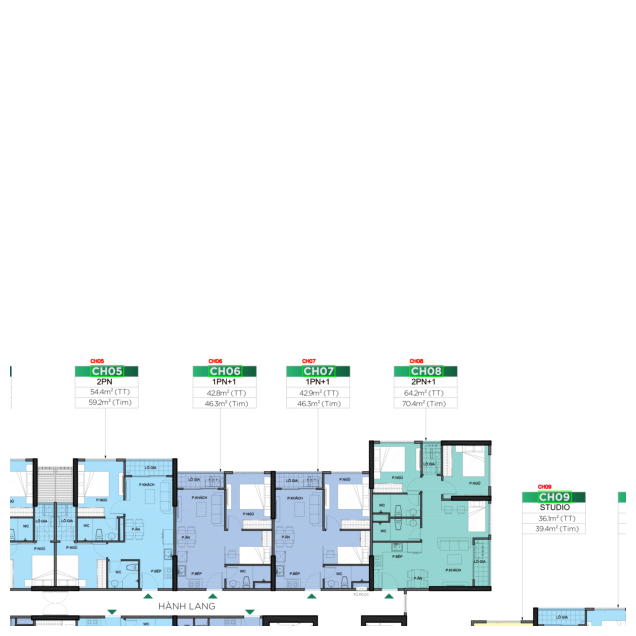

In [13]:
img_vis = design_cropped.copy()
for bbox, text in filtered_results:
    pts = np.array(bbox, dtype=np.int32)
    cv2.polylines(img_vis, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

    x, y = pts[0]
    cv2.putText(img_vis, text, (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(12, 8))
plt.imshow(img_vis)
plt.axis("off")
plt.show()

### Explore map

(2304, 2304, 3)
(922, 922, 3)


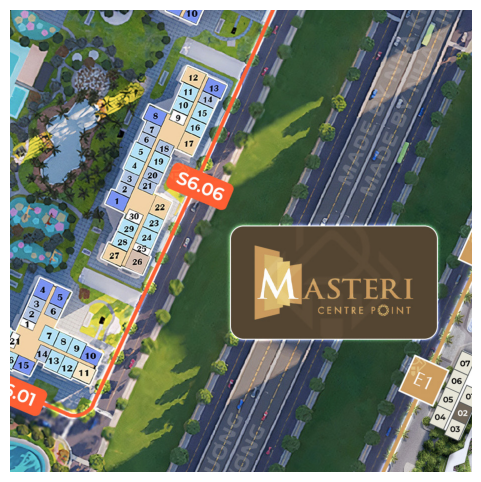

In [14]:
map_cropped = crop_from_original(map_resources, building_code)
print(map_cropped.shape)

h, w = map_cropped.shape[:2]
margin_ratio = 0.3
dx = int(w * margin_ratio)
dy = int(h * margin_ratio)
img_resized = map_cropped[dy:h - dy, dx:w - dx]
print(img_resized.shape)

plt.figure(figsize=(6, 6))
plt.imshow(img_resized)
plt.axis("off")
plt.show()

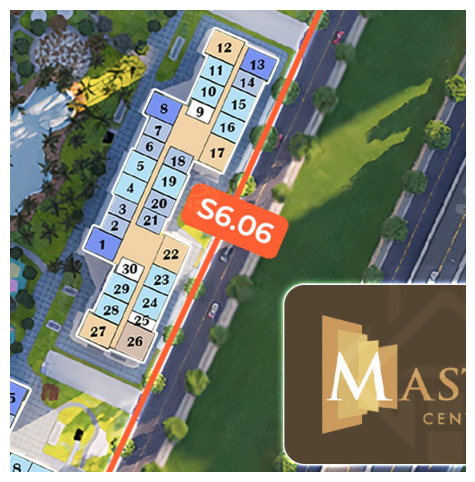

In [15]:
chosen_bbox = crop_building(img_resized, building_code)
img_cropped = crop_building_region(img_resized, chosen_bbox, building_code=building_code)
plt.figure(figsize=(6,6))
plt.imshow(img_cropped)
plt.axis("off")
plt.show()

In [16]:
yolo_results = yolo.predict(
    source=img_cropped,
    conf=0.4,
    imgsz=640,
    show=False, 
    verbose=False
)

obb_array = yolo_results[0].obb.xyxyxyxyn.cpu().numpy()
class_ids = yolo_results[0].obb.cls.cpu().numpy().astype(int)

centers = obb_array.reshape(-1, 4, 2).mean(axis=1)
clustering = DBSCAN(eps=0.1, min_samples=1).fit(centers)
labels = clustering.labels_

cluster_counts = Counter(labels)
largest_cluster = max(cluster_counts, key=cluster_counts.get)
print(f"Cluster có nhiều sample nhất: {largest_cluster}, với {cluster_counts[largest_cluster]} mẫu")

obb_largest = obb_array[labels == largest_cluster]
cls_largest = class_ids[labels == largest_cluster]

print("Các nhãn (class) trong cluster lớn nhất:", cls_largest)

Cluster có nhiều sample nhất: 0, với 31 mẫu
Các nhãn (class) trong cluster lớn nhất: [12 14 21 16 28  3 26  4 11 15 18  0 20 25 23 29  6  8 22 19  9  2  5 22  1 13  7 24 10 24 21]


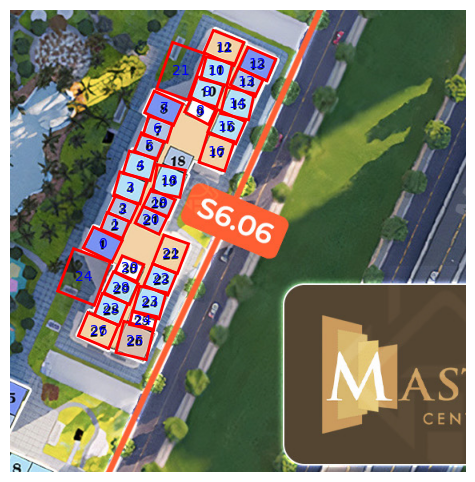

In [17]:
img_vis = img_cropped.copy()
h, w = img_vis.shape[:2]
plt.figure(figsize=(6,6))
plt.imshow(img_vis)
plt.axis('off')

for obb, cls_id in zip(obb_largest, cls_largest):
    coords = obb.reshape(4,2)
    coords[:,0] *= w
    coords[:,1] *= h
    tmp = coords.astype(np.int32)
    plt.fill(tmp[:,0], tmp[:,1], edgecolor='red', fill=False, linewidth=2)
    cx, cy = tmp[:,0].mean(), tmp[:,1].mean()
    plt.text(cx, cy, str(cls_id), color='blue', fontsize=10, ha='center', va='center')

plt.show()